When to run:
- After running the datalog engine and the csv files have been created (CCTX_Withdrawals.csv and CCTX_Deposits.csv)

Functionality:
- Calculates the value in USD transacted in each cross-chain transaction
- Calculates the time difference between transactions in each chain pertaining to the same cross-chain transaction

In [1]:
pip install pandas matplotlib python-dotenv requests;


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [7]:
MAP_SRC_DST_TOKENS = {
    "0xba8d75baccc4d5c4bd814fde69267213052ea663": "0xacc15dc74880c9944775448304b263d191c6077f", #WGLMR
    "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48": "0x8f552a71efe5eefc207bf75485b356a0b3f01ec9", #USDC
    "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2": "0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7", #WETH
    "0x2260fac5e5542a773aa44fbcfedf7c193bc2c599": "0x1dc78acda13a8bc4408b207c9e48cdbc096d95e0", #WBTC
    "0x6b175474e89094c44da98b954eedeac495271d0f": "0xc234a67a4f840e61ade794be47de455361b52413", #DAI 
    "0xdac17f958d2ee523a2206206994597c13d831ec7": "0x8e70cd5b4ff3f62659049e74b6649c6603a0e594", #USDT
    "0xd417144312dbf50465b1c641d016962017ef6240": "0x5130ca61bf02618548dfc3fdef50b50b36b11f2b", #CQT
    "0x853d955acef822db058eb8505911ed77f175b99e": "0x8d6e233106733c7cc1ba962f8de9e4dcd3b0308e", #FRAX
    "0x0bf0d26a527384bcc4072a6e2bca3fc79e49fa2d": "0xf42bd09c48498afa3993c00e226e97841d5789a7", #MYT
    "0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0": "0x21a8daca6a56434bdb6f39e7616c0f9891829aec", #FXS
}

MAP_TOKEN_TO_ID = {
    "0xacc15dc74880c9944775448304b263d191c6077f": "moonbeam",
    "0x8f552a71efe5eefc207bf75485b356a0b3f01ec9": "usdc",
    "0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7": "weth",
    "0x1dc78acda13a8bc4408b207c9e48cdbc096d95e0": "wrapped-bitcoin",
    "0xc234a67a4f840e61ade794be47de455361b52413": "dai",
    "0x8e70cd5b4ff3f62659049e74b6649c6603a0e594": "tether-usdt",
    "0x5130ca61bf02618548dfc3fdef50b50b36b11f2b": "covalent",
    "0x8d6e233106733c7cc1ba962f8de9e4dcd3b0308e": "frax",
    "0xf42bd09c48498afa3993c00e226e97841d5789a7": "none",   # cannot retreive the price of this token, but it is always around 0.00000XXX, so we will just consider 0
    "0x21a8daca6a56434bdb6f39e7616c0f9891829aec": "frax-share",
}

MAP_TOKEN_TO_DECIMALS = {
    "0xacc15dc74880c9944775448304b263d191c6077f": 18,
    "0x8f552a71efe5eefc207bf75485b356a0b3f01ec9": 6,
    "0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7": 18,
    "0x1dc78acda13a8bc4408b207c9e48cdbc096d95e0": 8,
    "0xc234a67a4f840e61ade794be47de455361b52413": 18,
    "0x8e70cd5b4ff3f62659049e74b6649c6603a0e594": 6,
    "0x5130ca61bf02618548dfc3fdef50b50b36b11f2b": 18,
    "0x8d6e233106733c7cc1ba962f8de9e4dcd3b0308e": 18,
    "0xf42bd09c48498afa3993c00e226e97841d5789a7": 0,
    "0x21a8daca6a56434bdb6f39e7616c0f9891829aec": 18,
}

In [6]:
# Add to the data frame the value being transferred in USD, based on the price of the token at that date
def calculateTxValueInUSD(token_address, value, day):
    token_id = MAP_TOKEN_TO_ID[token_address]

    if token_id == "none":
        return np.nan
    
    df_token_price = pd.read_csv(f"../../data/nomad-bridge/token_prices/{token_id}_historical_data.csv")

    try:
        price = df_token_price[df_token_price['date'] == day].iloc[0]['price']
        tx_volume = int(value) / (10**(MAP_TOKEN_TO_DECIMALS[token_address])) * price
        return tx_volume
    except KeyError:
        raise KeyError(f"The key '{token_address}' was not present in token the dictionary.")

In [20]:
def addTransactionTimeDifferencesToDataframe(cctxs, time_interval_days):
    # Calculate time differences
    cctxs['time_difference'] = pd.to_numeric(cctxs.iloc[:, 4], errors='coerce') - pd.to_numeric(cctxs.iloc[:, 1], errors='coerce')

    # # Convert Unix timestamps to datetime objects
    # cctxs.iloc[:, 1] = pd.to_numeric(cctxs.iloc[:, 1])
    # cctxs.iloc[:, 4] = pd.to_numeric(cctxs.iloc[:, 4])

    print("NUMBER OF DATAPOINTS:", len(cctxs['time_difference']))
    print("MAX CCTX LATENCY:", max(cctxs['time_difference']))
    print("MIN CCTX LATENCY:", min(cctxs['time_difference']))
    print("AVG CCTX LATENCY:", sum(cctxs['time_difference'])/len(cctxs['time_difference']))
    print("AVG CCTX LATENCY (MINS):", sum(cctxs['time_difference'])/len(cctxs['time_difference'])/60)
    print("AVG CCTX LATENCY (HOURS):", sum(cctxs['time_difference'])/len(cctxs['time_difference'])/60/60)
    print("AVG CCTX LATENCY (DAYS):", sum(cctxs['time_difference'])/len(cctxs['time_difference'])/60/60/24)

    # Round hour to the nearest multiple of time_interval_days (e.g., 15 represents periods of 15 days)
    cctxs['day_rounded'] = (pd.to_datetime(cctxs.iloc[:, 1], unit='s').dt.day // time_interval_days) * time_interval_days

    # Create a new column combining year, month, day, and rounded hour
    cctxs['datetime_group'] = pd.to_datetime(cctxs.iloc[:, 1], unit='s').dt.strftime('%Y-%m-') + cctxs['day_rounded'].astype(str).str.zfill(2) + " 00:00"

    return cctxs

In [28]:
def plotTimeDifferencesBoxplot(cctxs, logScale, title):
    ax = cctxs.boxplot(column='time_difference', by='datetime_group', grid=True)

    plt.suptitle('')
    plt.xticks(rotation=90)
    ax.set_title(title)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Time Difference (seconds)')
    if logScale:
        ax.set_yscale('log')
    plt.show()

# Analysis on the data of the selected interval

## CCTX Deposits

In [273]:
# Calculate USD value for each cctx

cctxs_deposits = pd.read_csv("../datalog/nomad-bridge/results/CCTX_Deposit.csv", header=None, sep='\t')
cctxs_deposits["value_usd"] = None

for index, row in cctxs_deposits.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[8], row.loc[11], day)
    cctxs_deposits.at[index, "value_usd"] = tx_volume

In [274]:
print(f"Total Value Deposited in USD: ${cctxs_deposits['value_usd'].sum():.2f}")
print(f"Total Value Deposited in Million USD: ${cctxs_deposits['value_usd'].sum() / 10**6:.2f}M")

Total Value Deposited in USD: $365185745.65
Total Value Deposited in Million USD: $365.19M


In [275]:
addTransactionTimeDifferencesToDataframe(cctxs_deposits, 7).head()

NUMBER OF DATAPOINTS: 11254
MAX CCTX LATENCY: 10618947
MIN CCTX LATENCY: 87
AVG CCTX LATENCY: 90278.59072329839
AVG CCTX LATENCY (MINS): 1504.6431787216397
AVG CCTX LATENCY (HOURS): 25.07738631202733
AVG CCTX LATENCY (DAYS): 1.044891096334472


,0,1,2,3,4,5,6,7,8,9,10,11,value_usd,time_difference,day_rounded,datetime_group
0,6648936,1641902381,0xa51f6536edb8eefdf9b204eaa4cdf9086156b9fed0c4...,1650811245,1641906546,0x9dd2711199aa3b0f97f847f56937c7fc2963ae650ffe...,0,0xdac17f958d2ee523a2206206994597c13d831ec7,0x8e70cd5b4ff3f62659049e74b6649c6603a0e594,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,13000000,13.003766,4165,7,2022-01-07 00:00
1,6648936,1641902381,0xdeed77b075575fb2b7922395ed1f8373b9aaea8be795...,1650811245,1641906672,0xc5fadbe9a551fa8e0b4bc045b150647553f9e5e6e75f...,1,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,9674180,9.672239,4291,7,2022-01-07 00:00
2,6648936,1641902412,0x2a041801a2d51a4436e88d07f7d8538cc5f3ede9cd52...,1650811245,1641906798,0x6c9391a28f34e21a54ccbb3b5047eab5a751f5181e38...,2,0x6b175474e89094c44da98b954eedeac495271d0f,0xc234a67a4f840e61ade794be47de455361b52413,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,2375430000000000000,2.378101,4386,7,2022-01-07 00:00
3,6648936,1641902516,0x0f94ca804282a0aa119a6477dd85c188411cdd1cc879...,1650811245,1641906942,0xff3698288619accc4eb458ee237e507a579164f8e7b1...,3,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x1dc78acda13a8bc4408b207c9e48cdbc096d95e0,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,120811,53.029174,4426,7,2022-01-07 00:00
4,6648936,1641902789,0xbae87a357dfa789164764c90635b336cc5bbe56274af...,1650811245,1641907098,0xe6b6029910c0ef6ad983cac06256b87946f5e9e26d37...,4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,10000000000000000,33.788957,4309,7,2022-01-07 00:00


Correlation between Latency and Value transferred: -0.014533123292765123


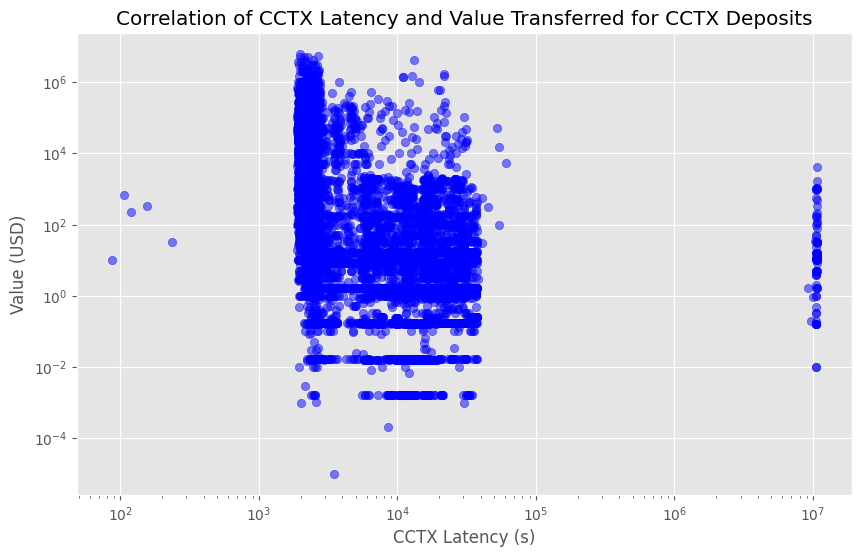

In [276]:
correlation = cctxs_deposits['time_difference'].corr(cctxs_deposits['value_usd'])
print("Correlation between Latency and Value transferred:", correlation)

plt.figure(figsize=(10, 6))
plt.scatter(cctxs_deposits['time_difference'], cctxs_deposits['value_usd'], color='blue', alpha=0.5)
plt.title('Correlation of CCTX Latency and Value Transferred for CCTX Deposits')
plt.xlabel('CCTX Latency (s)')
plt.ylabel('Value (USD)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

Há 5 txs cujo diff é menor que 30 minutos, contrariamente ao que diz nos [docs](https://docs.nomad.xyz/the-nomad-protocol/security/root-of-trust/fraud/optimistic-timeout-period)

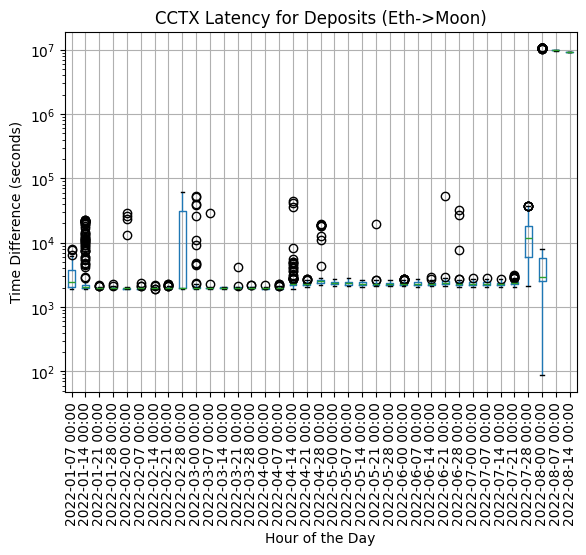

In [33]:
plotTimeDifferencesBoxplot(cctxs_deposits, True, "CCTX Latency for Deposits (Eth->Moon)")

## CCTX Withdrawal

In [23]:
cctxs_withdrawal = pd.read_csv("../datalog/nomad-bridge/results/CCTX_Withdrawal.csv", header=None, sep='\t')
cctxs_withdrawal["value_usd"] = None

for index, row in cctxs_withdrawal.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    cctxs_withdrawal.at[index, "value_usd"] = tx_volume

In [24]:
print(f"Total Value Withdrawn in USD: ${cctxs_withdrawal['value_usd'].sum():.2f}")
print(f"Total Value Withdrawn in Million USD: ${cctxs_withdrawal['value_usd'].sum() / 10**6:.2f}M")

Total Value Withdrawn in USD: $222097749.93
Total Value Withdrawn in Million USD: $222.10M


In [35]:
addTransactionTimeDifferencesToDataframe(cctxs_withdrawal, 7).head()

NUMBER OF DATAPOINTS: 4450
MAX CCTX LATENCY: 13708549
MIN CCTX LATENCY: 1860
AVG CCTX LATENCY: 183651.78292134832
AVG CCTX LATENCY (MINS): 3060.863048689139
AVG CCTX LATENCY (HOURS): 51.01438414481898
AVG CCTX LATENCY (DAYS): 2.1255993393674575


,0,1,2,3,4,5,6,7,8,9,10,11,value_usd,time_difference,day_rounded,datetime_group
0,1650811245,1641905736,0x7e641db161cf1afd984c4e2f0f1fe519eb976f18041e...,6648936,1641907661,0x64a8fd7047329f95631abdfcfbf224ad78e8e5d8fb61...,1,0xacc15dc74880c9944775448304b263d191c6077f,0xba8d75baccc4d5c4bd814fde69267213052ea663,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,1000000000000000000,8.971502,1925,7,2022-01-07 00:00
1,1650811245,1641977622,0xa8070d98c33968156c25fe4cf6d5c91ab1b7f2476938...,6648936,1641982002,0x60e20861d22a6931d9731e0c00dcd6984857140c86cf...,3,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x26bc3110960b1888c4bd043dbd16a6c7336ab488,0x26bc3110960b1888c4bd043dbd16a6c7336ab488,1915131000000000000,6232.679048,4380,7,2022-01-07 00:00
2,1650811245,1642027368,0x575deb2e509ae772a561c230ccdacb0b360bc364bef4...,6648936,1642029545,0x73bae115015885371b295daad8225493571b6963f550...,4,0xc234a67a4f840e61ade794be47de455361b52413,0x6b175474e89094c44da98b954eedeac495271d0f,0xa98c5eaffd2e339f2c67a922b39008938044baaa,0xa98c5eaffd2e339f2c67a922b39008938044baaa,54815000000000000000000,54756.474353,2177,7,2022-01-07 00:00
3,1650811245,1642075632,0xd46e8ef3d34d703e2486c70137dcba7062b9ca017f0a...,6648936,1642086325,0xbe2a5c91c7ae75ea52543e3aceb2a8cc662bc0c6173a...,8,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x09f258f399c421afff697ff75caca4ba3c73f02b,0x09f258f399c421afff697ff75caca4ba3c73f02b,1699000000000000000,5618.710559,10693,7,2022-01-07 00:00
4,1650811245,1642075620,0x8aec0ef676f30254a43362e3c745ec2e25c456708f61...,6648936,1642086569,0x46c559ec63879c00c6b4b36863d71e08496ceec241fe...,7,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xf08961d8863c0535253061bcb7ec10034adacd60,0xf08961d8863c0535253061bcb7ec10034adacd60,1699900000000000000,5621.686921,10949,7,2022-01-07 00:00


Correlation between Latency and Value transferred: -0.02220770398980122


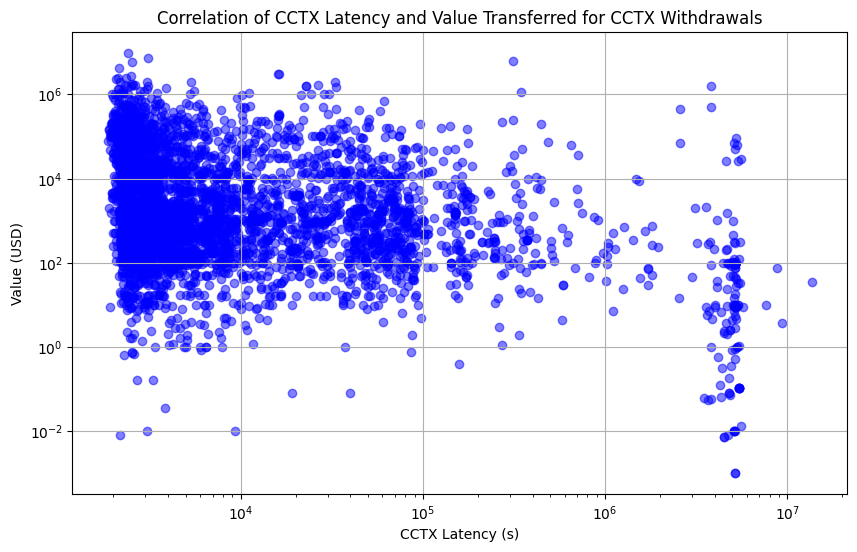

In [37]:
correlation = cctxs_withdrawal['time_difference'].corr(cctxs_withdrawal['value_usd'])
print("Correlation between Latency and Value transferred:", correlation)

plt.figure(figsize=(10, 6))
plt.scatter(cctxs_withdrawal['time_difference'], cctxs_withdrawal['value_usd'], color='blue', alpha=0.5)
plt.title('Correlation of CCTX Latency and Value Transferred for CCTX Withdrawals')
plt.xlabel('CCTX Latency (s)')
plt.ylabel('Value (USD)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

**Notes to add in the paper:**
The amount of time it takes for transactions to complete does not seem to affect the transaction value in a linear way -- i.e., higher value transactions do not necessarily take longer time to process.
Actually, the plot shows that the whole range of transferred values swipe the entire plot across all possible latencies of cross-chain transactions.

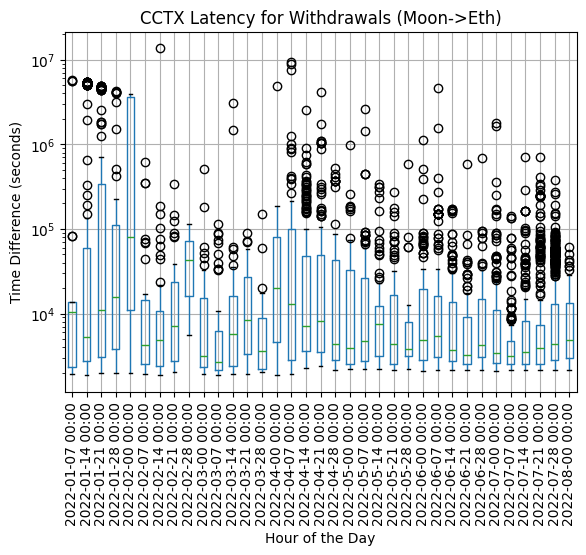

In [44]:
plotTimeDifferencesBoxplot(cctxs, True, "CCTX Latency for Withdrawals (Moon->Eth)")

This variability in the latency of cctxs from Ronin->Ethereum is explained by:
- the users need to perform the final transfer to Ethereum such that the bridge operator does not have to pay for the gas fees
- some users to not have funds in their address in Ethereum, therefore delay the final withdrawal on Ethereum

### Unmatched SC_ValidERC20TokenDeposited

In [41]:
deposited = pd.read_csv("../datalog/nomad-bridge/results/SC_DepositsWithoutMatch.csv", header=None, sep='\t')
deposited["value_usd"] = None

deposited["date"] = pd.to_datetime(deposited.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in deposited.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[6], row.loc[9], day)
    deposited.at[index, "value_usd"] = tx_volume

print(len(deposited))
deposited.head()

1


,0,1,2,3,4,5,6,7,8,9,value_usd,date
0,6648936,1659395165,0x794135750db90cf346b08dc3de668cb19ea69f59bc59...,1650811245,11367,0x6b175474e89094c44da98b954eedeac495271d0f,0xc234a67a4f840e61ade794be47de455361b52413,0x33333331d5205cc38e34a1c245df69985b9e5be5,0x33333331d5205cc38e34a1c245df69985b9e5be5,10000000000000000000,9.996642,2022-08-01 23:06


### Unmatched TC_ValidERC20TokenDeposited

In [43]:
deposited = pd.read_csv("../datalog/nomad-bridge/results/TC_DepositsWithoutMatch.csv", header=None, sep='\t')
deposited["value_usd"] = None

deposited["date"] = pd.to_datetime(deposited.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in deposited.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    try:
        tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[6], day)
        deposited.at[index, "value_usd"] = tx_volume
    except Exception as e:
        tx_volume = np.nan

print(len(deposited))
deposited.head()

9


,0,1,2,3,4,5,6,value_usd,date
0,1650811245,1651224792,0x3a5b7663d66c6d265d8d70081dc9d2dc5d85a97a5f73...,2164,0x8be1680d1ff72382f312ca3a207441043c8f9cec,0x4180e90db112047e588b1037db8ed8235c9e1382,200000000000000000000,None,2022-04-29 09:33
1,1650811245,1651308192,0x7fe7e6ea905831d135514fd665d9867349b24134f0dd...,2194,0x68a833447335c96d76d6f1aa8151c7e12ab5527e,0xbc65a184a8967880eed8900ca878c7dc49d2880b,1000000000000000000,None,2022-04-30 08:43
2,1650811245,1651335264,0x398d416d93d129f065f0b609160ffdfb36ae57b518ee...,2201,0xa742fafe323aab537aa5b38f6c5d421219161b81,0xbc65a184a8967880eed8900ca878c7dc49d2880b,2000000000000000000,None,2022-04-30 16:14
3,1650811245,1651335354,0x008f1c99e66186b0888f7c0318845075cc006967efc4...,2203,0xa742fafe323aab537aa5b38f6c5d421219161b81,0xbc65a184a8967880eed8900ca878c7dc49d2880b,2000000000000000000,None,2022-04-30 16:15
4,1650811245,1651335498,0xe539270c2d98212fab82546b467a91657b6de76af0a9...,2206,0xa742fafe323aab537aa5b38f6c5d421219161b81,0xbc65a184a8967880eed8900ca878c7dc49d2880b,28700000000000000000000000,None,2022-04-30 16:18


These are all about tokens that are not mapped...

### Unmatched TC_ValidNativeTokenWithdrawal and TC_ValidERC20TokenWithdrawal

In [47]:
withdrawals = pd.read_csv("../datalog/nomad-bridge/results/TC_WithdrawalsWithoutMatch.csv", header=None, sep='\t')
withdrawals["value_usd"] = None

withdrawals["date"] = pd.to_datetime(withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[8], day)
    withdrawals.at[index, "value_usd"] = tx_volume

print(len(withdrawals))
withdrawals.head()

825


,0,1,2,3,4,5,6,7,8,value_usd,date
0,1650811245,1644206646,0x6dbcc55ed29940729b0863aa02d28c88256819125264...,644,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x2ecd872798b9850baf21796521b5a33c341f7f89,0x2ecd872798b9850baf21796521b5a33c341f7f89,214500000000000000,669.600355,2022-02-07 04:04
1,1650811245,1644251778,0x7e14b9e195e88938f2b96ebb03138e5b2695a3719294...,647,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x039174bb81fa247fb9be25f1559c6612006a4779,0x039174bb81fa247fb9be25f1559c6612006a4779,1000000,0.999171,2022-02-07 16:36
2,1650811245,1644383748,0x057d56e8a95658d54728aa09eb912e20ac67d194ce63...,659,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x02dde656d513034d4819285137a368f140d5deb5,0x02dde656d513034d4819285137a368f140d5deb5,9987000000000000,30.654699,2022-02-09 05:15
3,1650811245,1644449040,0x88a8414d11f2981a1ebff0859101687fe53d4b502f7d...,662,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,50000000,50.005127,2022-02-09 23:24
4,1650811245,1644518772,0xe64ff1d7579293b07164efe2f40cc9127a23afae075d...,669,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,618700,0.618309,2022-02-10 18:46


We retrieved additional data on Ethereum after the selected interval, which caused 99 withdrawals to be matched. But there are still transactions not matched...

In [48]:
withdrawals = pd.read_csv("../datalog/nomad-bridge/results/TC_WithdrawalsWithoutMatchWithAdditionalData.csv", header=None, sep='\t')
withdrawals["value_usd"] = None

withdrawals["date"] = pd.to_datetime(withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[8], day)
    withdrawals.at[index, "value_usd"] = tx_volume

print(len(withdrawals))
withdrawals.head()

726


,0,1,2,3,4,5,6,7,8,value_usd,date
0,1650811245,1644206646,0x6dbcc55ed29940729b0863aa02d28c88256819125264...,644,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x2ecd872798b9850baf21796521b5a33c341f7f89,0x2ecd872798b9850baf21796521b5a33c341f7f89,214500000000000000,669.600355,2022-02-07 04:04
1,1650811245,1644251778,0x7e14b9e195e88938f2b96ebb03138e5b2695a3719294...,647,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x039174bb81fa247fb9be25f1559c6612006a4779,0x039174bb81fa247fb9be25f1559c6612006a4779,1000000,0.999171,2022-02-07 16:36
2,1650811245,1644383748,0x057d56e8a95658d54728aa09eb912e20ac67d194ce63...,659,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x02dde656d513034d4819285137a368f140d5deb5,0x02dde656d513034d4819285137a368f140d5deb5,9987000000000000,30.654699,2022-02-09 05:15
3,1650811245,1644449040,0x88a8414d11f2981a1ebff0859101687fe53d4b502f7d...,662,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,50000000,50.005127,2022-02-09 23:24
4,1650811245,1644518772,0xe64ff1d7579293b07164efe2f40cc9127a23afae075d...,669,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,618700,0.618309,2022-02-10 18:46


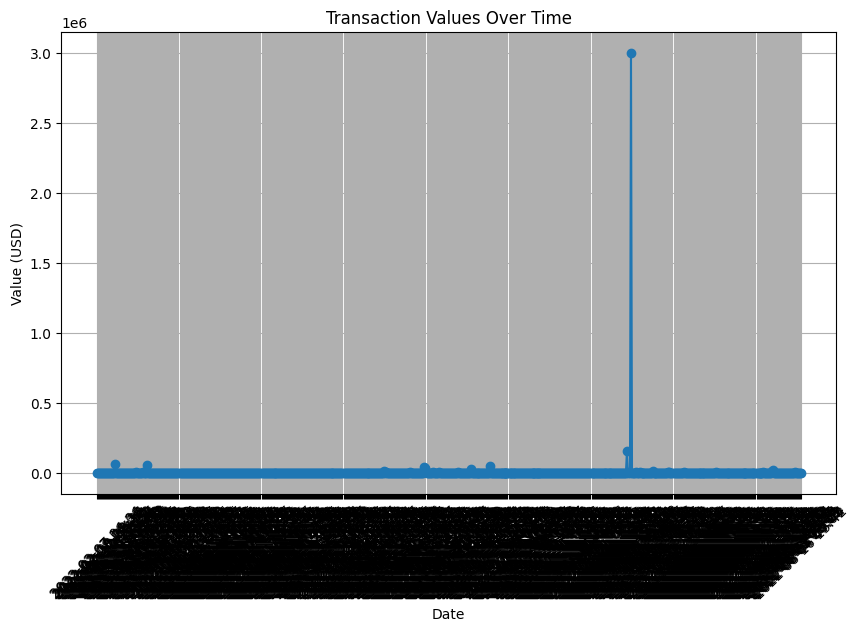

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(withdrawals['date'], withdrawals['value_usd'], marker='o')
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.title('Transaction Values Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Some analysis on this data:

Users try to withdraw tokens but since the destination address does not have any funds to cover gas fees, there is no match on Ethereum.

This problem is not verified on the other end (ethereum -> moonbeam) because the transaction is always issued by the same address 0x776a9097e01de7e7aa2ddd92989f27c8b5c3ae68!!!

We need to get data on the addresses to which the withdrawals are being done. The main question is whether they had enough funds to cover transaction fees.

In [50]:
def create_df_with_ethereum_addresses_involved_in_unmatched_withdrawal(df):
    # Lets only store the date of tx and the destination address
    selected_columns_by_name = df[['date', 'value_usd']]

    selected_col2_by_index = df.iloc[:, 1].rename('timestamp')
    selected_col3_by_index = df.iloc[:, 2].rename('tx_hash')
    selected_col8_by_index = df.iloc[:, 7].rename('dst_address')

    dst_ethereum_addresses = pd.concat([selected_columns_by_name, selected_col2_by_index, selected_col3_by_index, selected_col8_by_index], axis=1)

    dst_ethereum_addresses['dst_address_balance_at_date'] = '0'
    dst_ethereum_addresses['dst_address_balance_today'] = '0'
    # Display the new DataFrame
    return dst_ethereum_addresses

In [51]:
dst_ethereum_addresses = create_df_with_ethereum_addresses_involved_in_unmatched_withdrawal(withdrawals)
print(len(dst_ethereum_addresses))
dst_ethereum_addresses.head()

726


,date,value_usd,timestamp,tx_hash,dst_address,dst_address_balance_at_date,dst_address_balance_today
0,2022-02-07 04:04,669.600355,1644206646,0x6dbcc55ed29940729b0863aa02d28c88256819125264...,0x2ecd872798b9850baf21796521b5a33c341f7f89,0,0
1,2022-02-07 16:36,0.999171,1644251778,0x7e14b9e195e88938f2b96ebb03138e5b2695a3719294...,0x039174bb81fa247fb9be25f1559c6612006a4779,0,0
2,2022-02-09 05:15,30.654699,1644383748,0x057d56e8a95658d54728aa09eb912e20ac67d194ce63...,0x02dde656d513034d4819285137a368f140d5deb5,0,0
3,2022-02-09 23:24,50.005127,1644449040,0x88a8414d11f2981a1ebff0859101687fe53d4b502f7d...,0xdfda0825ec6a7163c9ce15d576225c3f5f663795,0,0
4,2022-02-10 18:46,0.618309,1644518772,0xe64ff1d7579293b07164efe2f40cc9127a23afae075d...,0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244,0,0


In [62]:
from dotenv import load_dotenv
import requests
import json
import os

load_dotenv()

def get_api_key():
    return os.getenv('BLOCKDAEMON_API_KEY')

RPC_URL = f'https://svc.blockdaemon.com/ethereum/mainnet/native'  # Replace 'KEY' with your actual API key
REQ_HEADERS = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'X-API-Key': get_api_key()
}
REQ_DATA = {
    "id": 1,
    "jsonrpc": "2.0",
    "params": [],
    "method": "eth_getBalance"
}

blocks_df = pd.read_csv("../../data/nomad-bridge/blocks/ethereum.csv")
blocks_df['timestamp'] = blocks_df['timestamp'].astype(int)

In [65]:
# We are going to retrieve the balance of each user on Ethereum, at the time the transaction on Moonbeam was issued, to see if the address had enough funds to cover for gas fees
# Therefore, we find the block number on Ethereum nearest to a certain timestamp and use the eth_getBalance RPC method
def find_closest_block(target_timestamp):
    blocks_df['time_diff'] = (blocks_df['timestamp'] - target_timestamp).abs()
    
    closest_index = blocks_df['time_diff'].idxmin()
    
    return blocks_df.loc[closest_index, 'block_number']

def fill_dst_ethereum_addresses_balances():
    length = len(dst_ethereum_addresses)

    for index, row in dst_ethereum_addresses.iterrows():
        dst_address = row['dst_address']
        block_number = find_closest_block(row['timestamp'])

        REQ_DATA['params'] = [dst_address, hex(block_number)]
        response = requests.post(RPC_URL, headers=REQ_HEADERS, data=json.dumps(REQ_DATA))

        REQ_DATA['params'] = [dst_address, hex(20190684)] # this is the last finalized block (ethereum) at the date of writing this script
        response2 = requests.post(RPC_URL, headers=REQ_HEADERS, data=json.dumps(REQ_DATA))

        if response.status_code == 200:
            balance = str(int(response.json()["result"], 16))
            balance2 = str(int(response2.json()["result"], 16))
            print(f"{index+1}/{length} Address {dst_address} had balance {balance} in block no {block_number}; current balance: {balance2}")
            dst_ethereum_addresses.at[index, 'dst_address_balance_at_date'] = balance
            dst_ethereum_addresses.at[index, 'dst_address_balance_today'] = balance2

        else:
            with open("./errors.txt", "a") as error_file:
                error_file.write(f"Transaction failed: {dst_address}\n")

In [70]:
fill_dst_ethereum_addresses_balances()

1/726 Address 0x2ecd872798b9850baf21796521b5a33c341f7f89 had balance 545792226092325 in block no 14156714; current balance: 545792226092325
2/726 Address 0x039174bb81fa247fb9be25f1559c6612006a4779 had balance 0 in block no 14160062; current balance: 60027270030000
3/726 Address 0x02dde656d513034d4819285137a368f140d5deb5 had balance 185842214586000 in block no 14169945; current balance: 121616584366770
4/726 Address 0xdfda0825ec6a7163c9ce15d576225c3f5f663795 had balance 11859173778791254 in block no 14174818; current balance: 726064277349000
5/726 Address 0xf7abcfa42bf7e7d43d3d53c665ded80fdafb5244 had balance 0 in block no 14180022; current balance: 12483677104869434
6/726 Address 0x0775ea2a88db33038c4069e41dda8d963b64c2a8 had balance 2558633532454694429 in block no 14183619; current balance: 52223603240628815
7/726 Address 0x0cacc94621ef3cc70bfb5f1279a62369a91b1d83 had balance 147918034080299322 in block no 14190519; current balance: 16763618044101584
8/726 Address 0xe68176a9d8a4323ea3

In [75]:
dst_ethereum_addresses.to_csv("./nomad-bridge/dst_ethereum_addresses.csv", index=False)

In [270]:
size = len(dst_ethereum_addresses[dst_ethereum_addresses['dst_address_balance_at_date'] == '0'])
print(f"Txs in which the destination did not have funds to pay for tx fee on Ethereum: {size}")

size2 = len(dst_ethereum_addresses[dst_ethereum_addresses['dst_address_balance_at_date'].map(int) < 1100000000000000])
print(f"Txs in which the destination did not have funds to pay for tx fee on Ethereum: {size2}")

Txs in which the destination did not have funds to pay for tx fee on Ethereum: 121
Txs in which the destination did not have funds to pay for tx fee on Ethereum: 230


In [74]:
size = len(dst_ethereum_addresses[(dst_ethereum_addresses['dst_address_balance_at_date'] == '0') & (dst_ethereum_addresses['dst_address_balance_today'] == '0')])
print(f"Addresses that still today do not have funds on Ethereum: {size}")

Txs in which the destination did not have funds to pay for tx fee on Ethereum: 72


In [77]:
print(f"Total Value Withdrawn in USD: ${dst_ethereum_addresses['value_usd'].sum():.2f}")
print(f"Total Value Withdrawn in Million USD: ${dst_ethereum_addresses['value_usd'].sum() / 10**6:.2f}M")

Total Value Withdrawn in USD: $3615279.58
Total Value Withdrawn in Million USD: $3.62M


In [85]:
sorted_dst_ethereum_addresses = dst_ethereum_addresses.sort_values('value_usd', ascending=False)
sorted_dst_ethereum_addresses.head()

print("MAX:", max(dst_ethereum_addresses['value_usd']))
print("MIN:", min(dst_ethereum_addresses['value_usd']))
print("AVG:", sum(dst_ethereum_addresses['value_usd'])/len(dst_ethereum_addresses['value_usd']))
print("MEDIAN:", sorted_dst_ethereum_addresses['value_usd'].median())

MAX: 3000846.8665931956
MIN: 2.995264216e-11
AVG: 4979.723935130053
MEDIAN: 8.996540152146


So, there is one address (0x62a06Db859BDAf7060AC8290B156234Ce53FD6Cb) that, by itself, withdrew 3 Million USD but never withdrew those funds.

Actually, the address interacted 4 times with the bridge contract on Ethereum to deposit funds (100 USDC; 499 DAI; 1,000,000 USDC; 3,000,000 USDC). All these transactions are in our dataset as cross-chain transactions in CCTX_Deposit. However, they were never withdrawn. The address started 1 withdraw on the target chain that did not complete.

The rest of the transactions are kinda small in value. The median is 9 USD, which suggests there are a lot of different users that misuse the bridge and are not familiar with is internal functionality.

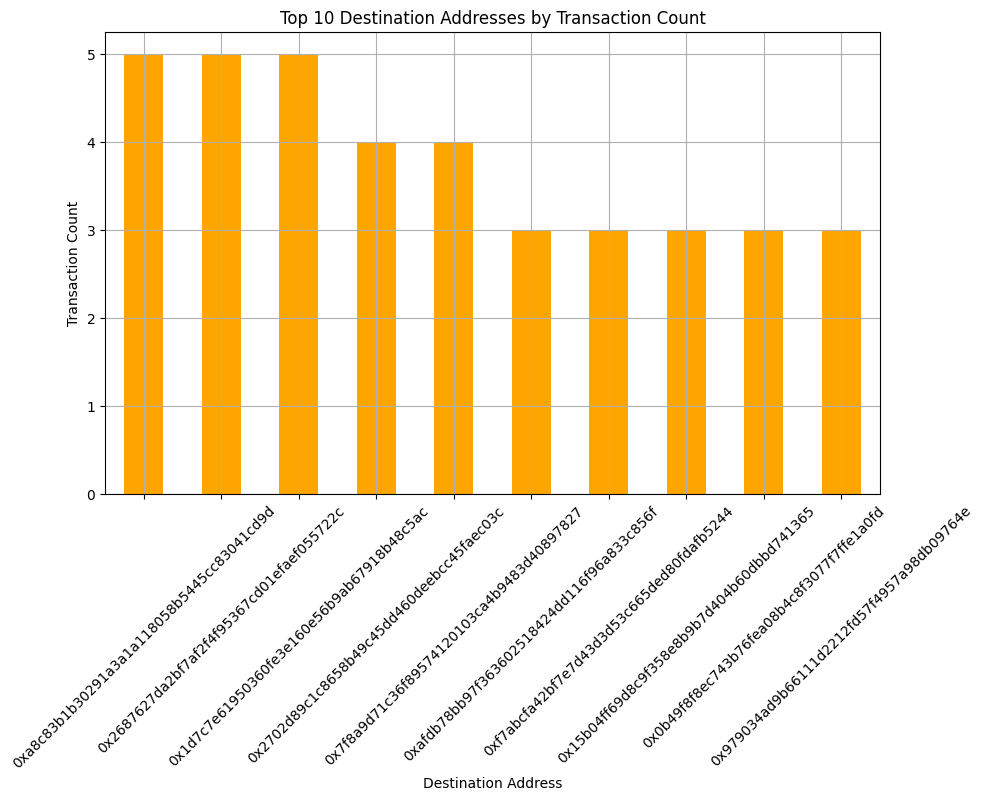

In [89]:
top_dst_addresses = sorted_dst_ethereum_addresses['dst_address'].value_counts().head(10)

# Bar plot
plt.figure(figsize=(10, 6))
top_dst_addresses.plot(kind='bar', color='orange')
plt.title('Top 10 Destination Addresses by Transaction Count')
plt.xlabel('Destination Address')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

There was one address that interacted with the bridge 5 times to withdraw funds but they were never withdrawn. These were made exactly at the time the bridge was hacked but not successful. Over the next hours, multiple transactions were issued to withdraw funds but none was successful because the contract on Ethereum was meanwhile paused.

This also shows the consequence of an attack, people wanting to withdraw funds from one blockchain to another to avoid using protocols.

In [95]:
before_attack_dst_ethereum_addresses = dst_ethereum_addresses[dst_ethereum_addresses['timestamp'] < 1659389551]
print(len(before_attack_dst_ethereum_addresses))

size = len(before_attack_dst_ethereum_addresses[(before_attack_dst_ethereum_addresses['dst_address_balance_at_date'] == '0') & (before_attack_dst_ethereum_addresses['dst_address_balance_today'] == '0')])
print(f"Addresses that still today do not have funds on Ethereum: {size}")

print(f"Total Value not Withdrawn in USD: ${before_attack_dst_ethereum_addresses['value_usd'].sum():.2f}")
print(f"Total Value not Withdrawn in Thousands USD: ${before_attack_dst_ethereum_addresses['value_usd'].sum() / 10**3:.2f}K")

538
Addresses that still today do not have funds on Ethereum: 55
Total Value Withdrawn in USD: $343708.98
Total Value Withdrawn in Thousands USD: $343.71K


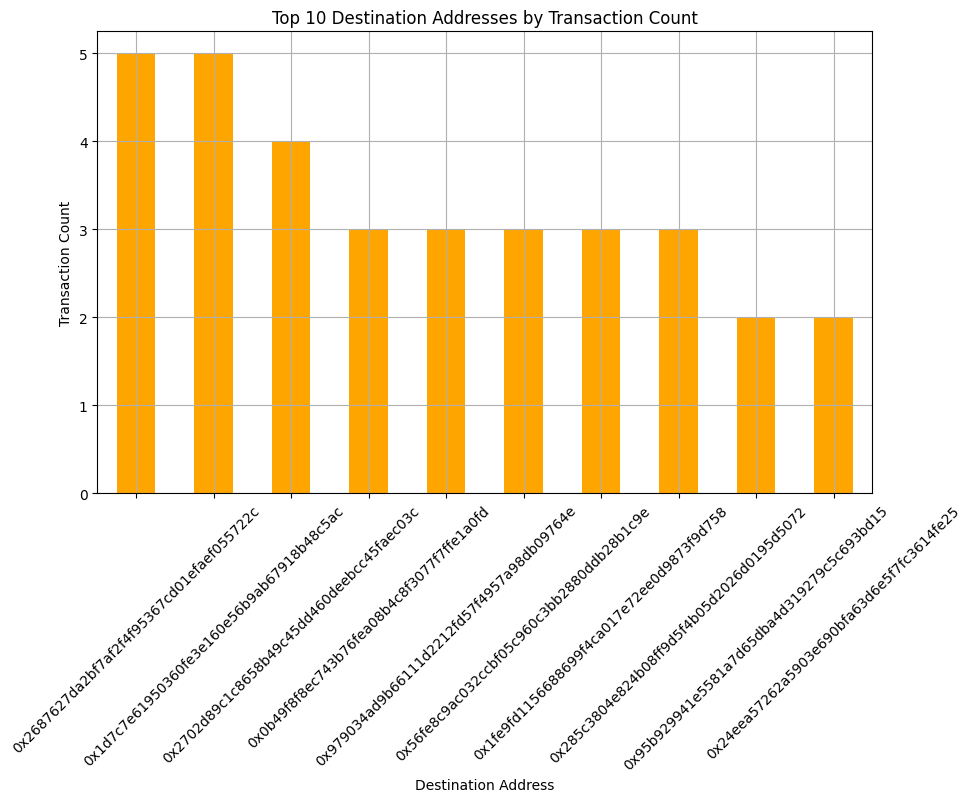

In [98]:
top_dst_addresses = before_attack_dst_ethereum_addresses['dst_address'].value_counts().head(10)

# Bar plot
plt.figure(figsize=(10, 6))
top_dst_addresses.plot(kind='bar', color='orange')
plt.title('Top 10 Destination Addresses by Transaction Count')
plt.xlabel('Destination Address')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [109]:
count_per_dst_address = before_attack_dst_ethereum_addresses['dst_address'].value_counts()
multiple_counts = len(count_per_dst_address[count_per_dst_address > 1])
single_counts = len(count_per_dst_address[count_per_dst_address == 1])
print("Number of addresses that tried withdrawing exactly once:", multiple_counts)
print("Number of addresses that tried withdrawing more than once:", single_counts)


Number of addresses that tried withdrawing exactly once: 33
Number of addresses that tried withdrawing more than once: 459


In [110]:
after_attack_dst_ethereum_addresses = dst_ethereum_addresses[dst_ethereum_addresses['timestamp'] >= 1659389551]
print(len(after_attack_dst_ethereum_addresses))

size = len(after_attack_dst_ethereum_addresses[(after_attack_dst_ethereum_addresses['dst_address_balance_at_date'] == '0') & (after_attack_dst_ethereum_addresses['dst_address_balance_today'] == '0')])
print(f"Addresses that still today do not have funds on Ethereum: {size}")

print(f"Total Value not Withdrawn in USD: ${after_attack_dst_ethereum_addresses['value_usd'].sum():.2f}")
print(f"Total Value not Withdrawn in Million USD: ${after_attack_dst_ethereum_addresses['value_usd'].sum() / 10**6:.2f}M")

188
Addresses that still today do not have funds on Ethereum: 17
Total Value not Withdrawn in USD: $3271570.60
Total Value not Withdrawn in Million USD: $3.27M


A provocative question... is a hack good or bad for bridges? They take users funds... If the hack is small enough it may compensate the value...

### Plot the difference between the withdrawal cross-chain transactions and the ones issued to the TC and not merged with any tx on the SC

This is a violation of a cross-chain rule, but not stealing funds from the bridge. Users are sending funds to the bridge and never withdrawing...

In [113]:
unmatched_cctxs_withdrawals = pd.read_csv("../datalog/nomad-bridge/results/TC_WithdrawalsWithoutMatch.csv", header=None, sep='\t')
unmatched_cctxs_withdrawals["value_usd"] = None

unmatched_cctxs_withdrawals["date"] = pd.to_datetime(unmatched_cctxs_withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in unmatched_cctxs_withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[8], day)
    unmatched_cctxs_withdrawals.at[index, "value_usd"] = tx_volume


matched_cctxs_withdrawals = pd.read_csv("../datalog/nomad-bridge/results/CCTX_Withdrawal.csv", header=None, sep='\t')
matched_cctxs_withdrawals["value_usd"] = None

matched_cctxs_withdrawals["date"] = pd.to_datetime(matched_cctxs_withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in matched_cctxs_withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    matched_cctxs_withdrawals.at[index, "value_usd"] = tx_volume


# Convert the 'date' column to datetime
unmatched_cctxs_withdrawals['date'] = pd.to_datetime(unmatched_cctxs_withdrawals['date'])
unmatched_cctxs_withdrawals.set_index('date', inplace=True)

matched_cctxs_withdrawals['date'] = pd.to_datetime(matched_cctxs_withdrawals['date'])
matched_cctxs_withdrawals.set_index('date', inplace=True)


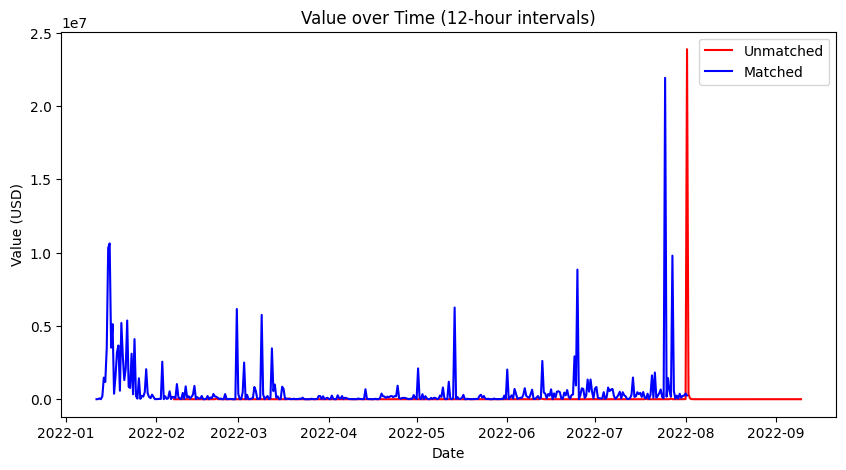

In [116]:
# Resample the data to 12-hour intervals and aggregate using the mean
unmatched_cctxs_withdrawals_resampled = unmatched_cctxs_withdrawals.resample('12h').sum()
matched_cctxs_withdrawals_resampled = matched_cctxs_withdrawals.resample('12h').sum()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(unmatched_cctxs_withdrawals_resampled.index, unmatched_cctxs_withdrawals_resampled["value_usd"], label='Unmatched', color='red')
plt.plot(matched_cctxs_withdrawals_resampled.index, matched_cctxs_withdrawals_resampled["value_usd"], label='Matched', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.title('Value over Time (12-hour intervals)')
plt.legend()


# Display the plot
plt.show()

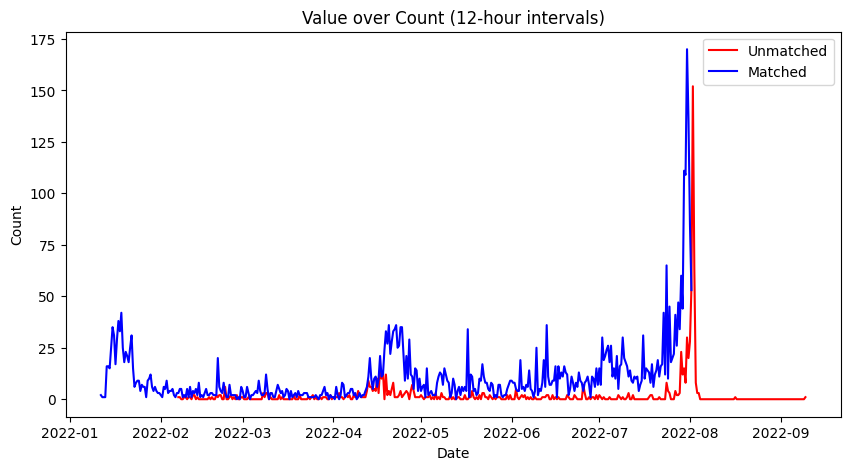

In [117]:
# Resample the data to 12-hour intervals and aggregate using the mean
unmatched_cctxs_withdrawals_resampled = unmatched_cctxs_withdrawals.resample('12h').count()
matched_cctxs_withdrawals_resampled = matched_cctxs_withdrawals.resample('12h').count()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(unmatched_cctxs_withdrawals_resampled.index, unmatched_cctxs_withdrawals_resampled["value_usd"], label='Unmatched', color='red')
plt.plot(matched_cctxs_withdrawals_resampled.index, matched_cctxs_withdrawals_resampled["value_usd"], label='Matched', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Value over Count (12-hour intervals)')
plt.legend()


# Display the plot
plt.show()

In [119]:
# Calculate USD value for each transaction

cctxs = pd.read_csv("../datalog/nomad-bridge/results/SC_ValidERC20TokenWithdrawal.csv", header=None, sep='\t')
cctxs["value_usd"] = None

cctxs["date"] = pd.to_datetime(cctxs.iloc[:, 0], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in cctxs.iterrows():
    day = datetime.fromtimestamp(row.loc[0]).strftime('%Y-%m-%d')
    try:
        dst_token = MAP_SRC_DST_TOKENS[row.loc[4]]
        tx_volume = calculateTxValueInUSD(MAP_SRC_DST_TOKENS[row.loc[4]], row.loc[6], day)
    except Exception as e:
        tx_volume = np.nan
    
    cctxs.at[index, "value_usd"] = tx_volume

cctxs['date'] = pd.to_datetime(cctxs['date'])
cctxs.set_index('date', inplace=True)

print(len(cctxs))
cctxs.head()

4869


,0,1,2,3,4,5,6,value_usd
date,,,,,,,,
2022-01-11 13:27:00,1641907661,0x64a8fd7047329f95631abdfcfbf224ad78e8e5d8fb61...,1,0xa5bd5c661f373256c0ccfbc628fd52de74f9bb55,0xba8d75baccc4d5c4bd814fde69267213052ea663,6648936,1000000000000000000,8.971502
2022-01-12 10:06:00,1641982002,0x60e20861d22a6931d9731e0c00dcd6984857140c86cf...,3,0x26bc3110960b1888c4bd043dbd16a6c7336ab488,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,6648936,1915131000000000000,6232.679048
2022-01-12 23:19:00,1642029545,0x73bae115015885371b295daad8225493571b6963f550...,4,0xa98c5eaffd2e339f2c67a922b39008938044baaa,0x6b175474e89094c44da98b954eedeac495271d0f,6648936,54815000000000000000000,54756.474353
2022-01-13 15:05:00,1642086325,0xbe2a5c91c7ae75ea52543e3aceb2a8cc662bc0c6173a...,8,0x09f258f399c421afff697ff75caca4ba3c73f02b,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,6648936,1699000000000000000,5618.710559
2022-01-13 15:09:00,1642086569,0x46c559ec63879c00c6b4b36863d71e08496ceec241fe...,7,0xf08961d8863c0535253061bcb7ec10034adacd60,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,6648936,1699900000000000000,5621.686921


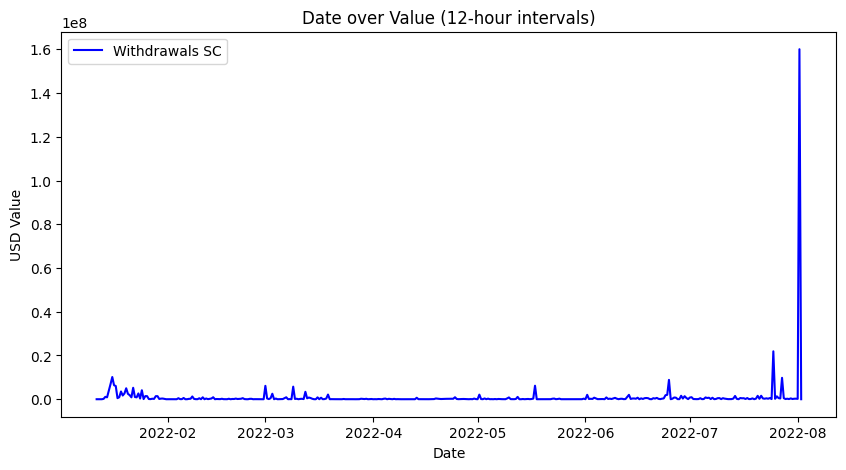

In [123]:
# Resample the data to 12-hour intervals and aggregate using the mean
withdrawals = cctxs.resample('12h').sum()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(withdrawals.index, withdrawals["value_usd"], label='Withdrawals SC', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('USD Value')
plt.title('Date over Value (12-hour intervals)')
plt.legend()


# Display the plot
plt.show()

In [125]:
# Calculate USD value for each transaction

cctxs = pd.read_csv("../datalog/nomad-bridge/results/SC_WithdrawalsWithoutMatch.csv", header=None, sep='\t')
cctxs["value_usd"] = None

cctxs["date"] = pd.to_datetime(cctxs.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in cctxs.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    try:
        dst_token = MAP_SRC_DST_TOKENS[row.loc[4]]
        tx_volume = calculateTxValueInUSD(MAP_SRC_DST_TOKENS[row.loc[4]], row.loc[6], day)
    except Exception as e:
        tx_volume = np.nan
    
    cctxs.at[index, "value_usd"] = tx_volume

print(len(cctxs))
cctxs.head()

419


,0,1,2,3,4,5,6,value_usd,date
0,6648936,1642623577,0xf3873df366084bb0b8ccbaed1af24120746fffa788d6...,312,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x3030303030303030303030303030353866423433,1000000,1.000412,2022-01-19 20:19
1,6648936,1643539288,0x726ab11eadb10b8162200a7eb0a6ea3be73157783240...,584,0xba8d75baccc4d5c4bd814fde69267213052ea663,0xa2fc8517367f05add3423f914aff77e17922bb9d,30000000000000000000,161.85558,2022-01-30 10:41
2,6648936,1647647738,0x1c6a6264c51dea4b4cc0f081a3663f702dd12d2cacdb...,310,0x853d955acef822db058eb8505911ed77f175b99e,0x3030303030303030303030303030353866423433,1000000000000000000,0.997608,2022-03-18 23:55
3,6648936,1647647779,0x6e1b23f2449ee1dd8f775b9aa25f5505406e999bbb10...,311,0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0,0x3030303030303030303030303030353866423433,1000000000000000000,17.722433,2022-03-18 23:56
4,6648936,1647649293,0x4609fa00a54f0df2801917085d4d701ceb34aa593875...,549,0xba8d75baccc4d5c4bd814fde69267213052ea663,0x467ea556ff83ae2a763f38f246bbb4f3f6e9558a,1000000000000000000,2.685641,2022-03-19 00:21


In [127]:
cctxs.fillna(0)
total_value = cctxs["value_usd"].sum()
total_addresses = cctxs.iloc[:,5].unique()
print("TOTAL UNIQUE ADDRESSES IDENTIFIED: " + str(len(total_addresses)))
print("TOTAL VALUE (USD): " + str(total_value))
print("TOTAL VALUE (MILLION USD): " + str(total_value / 10**6))

TOTAL UNIQUE ADDRESSES IDENTIFIED: 299
TOTAL VALUE (USD): 159637559.1886852
TOTAL VALUE (MILLION USD): 159.6375591886852


/var/folders/bb/lz0b6jv55n96zj41zzsd4pc80000gn/T/ipykernel_39859/4214297528.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cctxs.fillna(0)


In [128]:
cctxs.to_csv("./nomad-bridge/attacks.csv", index=False)

### Compare our dataset with existing one from Peckshield
The dataset from Peckshield aggregates the funds per EOA. Our dataset aggregates per contract, be it EOA or Contract Address. What happens multiple times is that one EOA deploys multiple contracts on the same transaction (or multiple) and then the funds are scattered among them. We will rely on transaction.facts (which contains to=null whenever there is a contract being deployed) and we will merge the data with this our dataset. Once we have a dataset with all EOAs and tokens stolen, we can compare the datasets.

In [130]:
# for each transaction (col 3) in df "cctxs", we will get the line corresponding to that tx in "transaction.facts"csv file (col 3).
# We will check col6. If col6 (to) is equal to None, then we extract the sender (col5) and store in the dataset the new column from cctxs 
# where col6 is replaced by this value

transaction_facts = pd.read_csv('../datalog/nomad-bridge/facts/transaction.facts', header=None, sep='\t')

# Set column names for clarity
cctxs.columns = ['col1', 'col2', 'tx_hash', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9']
transaction_facts.columns = ['col1', 'col2', 'tx_hash', 'col4', 'from', 'to', 'col7', 'col8', 'col9']

new_cctxs = cctxs.copy(deep=True)
new_cctxs.insert(6, 'corresponding_eoa', None)

for idx, row in cctxs.iterrows():
    tx_hash = row['tx_hash']

    corresponding_tx = transaction_facts[transaction_facts['tx_hash'] == tx_hash]

    from_value = corresponding_tx.iloc[0]['from']
    new_cctxs.at[idx, 'corresponding_eoa'] = from_value

# Display the new DataFrame
new_cctxs.head()

# Save the new DataFrame to a CSV file if needed
new_cctxs.to_csv('./nomad-bridge/modified_attacks.csv', index=False)

print("total unique EOAs:", len(new_cctxs["corresponding_eoa"].unique()))

total unique EOAs: 64


In [131]:
def load_and_compare_df_cols(col_1, col_2):
    # Get the difference between the "hashes" columns
    hashes1 = set(col_1)
    hashes2 = set(col_2)
    
    # Find elements in df1 that are not in df2
    diff1_to_2 = hashes1 - hashes2

    # Find elements in df2 that are not in df1
    diff2_to_1 = hashes2 - hashes1
    
    return diff1_to_2, diff2_to_1

In [133]:
peckshield_addresses = pd.read_csv("./nomad-bridge/all_addresses_peckshield.csv")

peckshield_misses, our_df_misses = load_and_compare_df_cols(new_cctxs["corresponding_eoa"], peckshield_addresses["address"])

print(f'Addresses highlighted by our data but not by Peckshield:')
print(len(peckshield_misses))
print(peckshield_misses)

print(f'Addresses highlighted by Peckshield not in our data:')
print(len(our_df_misses))
print(our_df_misses)

Addresses highlighted by our data but not by Peckshield:
28
{'0xde4a63d65bdb57fd33dc888d9f28a204dd036bd1', '0x57c8748a9918e78402884a1a9a105faebf11ae5a', '0x84c0430f3564520dcde45c3dfd7ceb79372e4fa3', '0xbc65a184a8967880eed8900ca878c7dc49d2880b', '0x4f2094a42e60d736868a7d4de868b8342fff06c6', '0x4081c2e9338aab51480acbb34f6664e32509b9f7', '0x36a87d1e3200225f881488e4aeedf25303febcae', '0x58d16473f5cfbd3970e624e9aeab5528af2d9a40', '0x5dc4b43165706d0fc8aad525fe7e32269c4e28b3', '0x808dd10aec73c683ad92a3f2af6c3b037c3ffbd1', '0x1a54220656fa426a20331141324260398a549314', '0x93bcf26c4dd1ad618251567f23568e1b836ff013', '0x648cb3eda2cd223789fa87739f50536367588f9a', '0xc9b1e89fe6847c5c0747c353e1a86aa0803881e5', '0xfac742b7e14538d4b7187249ed93e8674d9d3d7c', '0xc950a5b78898919660745436229d7a7e70fa2a6a', '0xaf26d799dd372ea983c40855a4085f6b765616b0', '0x4f95ad114fbddf8df0756017e9bc856e730b2796', '0x4180e90db112047e588b1037db8ed8235c9e1382', '0x2d3a838701c301b3c402c91b3b3f852b7adc0418', '0x9e11732a081020d1

In [138]:
# we then check the alternative_chains.facts and search for these addresses
txs_to_alternative_chains = pd.read_csv("../datalog/nomad-bridge/facts/alternative_chains.facts", header=None, sep="\t")

from_addresses = set(txs_to_alternative_chains.iloc[:,3])
count = 0

for address in our_df_misses:
    if address not in from_addresses:
        print("Missing Address")
    else:
        count += 1

print("Addresses highlighted out of scope in our analysis:", count)

Addresses highlighted out of scope in our analysis: 5


ALL ADDRESSES FOUND IN PECKSHIELD'S DATASET BETWEEN MOONBEAM AND ETHEREUM ARE IN OURS!!!

# Analysis on the data of the selected interval + additional data retrieved on Ethereum

In [266]:
cctxs = pd.read_csv("../datalog/nomad-bridge/results/TC_WithdrawalsMatchWithAdditionalData.csv", header=None, sep='\t')
cctxs["value_usd"] = None

for index, row in cctxs.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    cctxs.at[index, "value_usd"] = tx_volume

cctxs

,0,1,2,3,4,5,6,7,8,9,10,11,value_usd
0,1650811245,1658652534,0x66619fe90a04633cbdf1ddfc2dff595d097cac80f0fc...,6648936,1673117075,0x03f98ece290918b219334676987b283709298471250d...,3842,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc271e8e809505b9e46c7e60e8ed56a9b9814a796,0xc271e8e809505b9e46c7e60e8ed56a9b9814a796,100000000000000000,144.720699
1,1650811245,1659182436,0x04a446b6cd387efd495813ab4c6c291efc990d99884e...,6648936,1672601759,0xe8e46f506d2f24fef772b1e64b43e717a57c997c1459...,4416,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa223c7692d7a80c98a94ce0f2ac19dfeb8fd47ca,0xa223c7692d7a80c98a94ce0f2ac19dfeb8fd47ca,110000000000000000,185.315094
2,1650811245,1659261924,0x42f1b21e8e2d18f9e15ea0592e8aa06d9a8871371a4b...,6648936,1672285247,0x6a70ee30d39bce41bec1a0bbea7cbbc9cd467e8bc35c...,4689,0x8e70cd5b4ff3f62659049e74b6649c6603a0e594,0xdac17f958d2ee523a2206206994597c13d831ec7,0xc239876bdf21a9746b2da99622e323c53dd24740,0xc239876bdf21a9746b2da99622e323c53dd24740,650000000,650.132359
3,1650811245,1659261996,0x34e9440d67c6877699cbcd6dbd85e1e8d473f7d57ffb...,6648936,1672285775,0x4287d44d327d87456dde4b239670d4bd2bcecf98a967...,4690,0x8e70cd5b4ff3f62659049e74b6649c6603a0e594,0xdac17f958d2ee523a2206206994597c13d831ec7,0x201b856fe2d5539cbd325cd2c491ca75e4dfa2e7,0x201b856fe2d5539cbd325cd2c491ca75e4dfa2e7,457000000,457.093059
4,1650811245,1659262104,0xf48f6dd7577de452e9803b50292ffe07b2ca476ede30...,6648936,1672295867,0x4445e51270d99cf57510ae8a483e9be94d89ed827e7c...,4691,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x07ac816d88643a7140cba1624980a0c5e12e7a18,0x07ac816d88643a7140cba1624980a0c5e12e7a18,378000000,377.938526
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1650811245,1659471192,0x316959257904ef675dd9eedfd06f94c2df2bfca2e672...,6648936,1671805175,0x0cbc02f7ebef6ecb4038db2db652095a4624d67c5ad2...,5308,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x4deec6b68b3090fc7a7e7a494fc8fa65080c75e8,0x4deec6b68b3090fc7a7e7a494fc8fa65080c75e8,50000000000000000,80.881682
95,1650811245,1659484788,0x3e6cb18b3eb958e5f01d2154c8b1a5d6a1d8eb134329...,6648936,1671577751,0x567017bc96d6f804530b0ff28e689988bf0f21e87162...,5323,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x5f45b03ecff80eb6b4d5829661fd49a241f06a33,0x5f45b03ecff80eb6b4d5829661fd49a241f06a33,503214148,503.232467
96,1650811245,1659489240,0xdb3c25791d3d75053cc036c9fe9ea8410dba33add1c3...,6648936,1715057399,0x5b03906083c10a01a8271bde34d44f0eebdb977ccf7c...,5324,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x62c0c8a0456a977aa007326bb9d8cc1e9d3cc082,0x62c0c8a0456a977aa007326bb9d8cc1e9d3cc082,100000000,100.00364
97,1650811245,1659581208,0xc187339d83d31557cce0fea2f7cf345608388c840c96...,6648936,1676599607,0x8e9656371a20ee4d17393afdda86f0edada4c60d8f75...,5336,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xafea69a7f761be7b359b0f5daed8afff8ebca4fe,0xafea69a7f761be7b359b0f5daed8afff8ebca4fe,391631124,391.665417


In [267]:
addTransactionTimeDifferencesToDataframe(cctxs, 1).head()

NUMBER OF DATAPOINTS: 99
MAX CCTX LATENCY: 55568159
MIN CCTX LATENCY: 9388757
AVG CCTX LATENCY: 16329236.757575758
AVG CCTX LATENCY (MINS): 272153.94595959596
AVG CCTX LATENCY (HOURS): 4535.8990993266
AVG CCTX LATENCY (DAYS): 188.99579580527498


,0,1,2,3,4,5,6,7,8,9,10,11,value_usd,time_difference,day_rounded,datetime_group
0,1650811245,1658652534,0x66619fe90a04633cbdf1ddfc2dff595d097cac80f0fc...,6648936,1673117075,0x03f98ece290918b219334676987b283709298471250d...,3842,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc271e8e809505b9e46c7e60e8ed56a9b9814a796,0xc271e8e809505b9e46c7e60e8ed56a9b9814a796,100000000000000000,144.720699,14464541,24,2022-07-24 00:00
1,1650811245,1659182436,0x04a446b6cd387efd495813ab4c6c291efc990d99884e...,6648936,1672601759,0xe8e46f506d2f24fef772b1e64b43e717a57c997c1459...,4416,0x30d2a9f5fdf90ace8c17952cbb4ee48a55d916a7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa223c7692d7a80c98a94ce0f2ac19dfeb8fd47ca,0xa223c7692d7a80c98a94ce0f2ac19dfeb8fd47ca,110000000000000000,185.315094,13419323,30,2022-07-30 00:00
2,1650811245,1659261924,0x42f1b21e8e2d18f9e15ea0592e8aa06d9a8871371a4b...,6648936,1672285247,0x6a70ee30d39bce41bec1a0bbea7cbbc9cd467e8bc35c...,4689,0x8e70cd5b4ff3f62659049e74b6649c6603a0e594,0xdac17f958d2ee523a2206206994597c13d831ec7,0xc239876bdf21a9746b2da99622e323c53dd24740,0xc239876bdf21a9746b2da99622e323c53dd24740,650000000,650.132359,13023323,31,2022-07-31 00:00
3,1650811245,1659261996,0x34e9440d67c6877699cbcd6dbd85e1e8d473f7d57ffb...,6648936,1672285775,0x4287d44d327d87456dde4b239670d4bd2bcecf98a967...,4690,0x8e70cd5b4ff3f62659049e74b6649c6603a0e594,0xdac17f958d2ee523a2206206994597c13d831ec7,0x201b856fe2d5539cbd325cd2c491ca75e4dfa2e7,0x201b856fe2d5539cbd325cd2c491ca75e4dfa2e7,457000000,457.093059,13023779,31,2022-07-31 00:00
4,1650811245,1659262104,0xf48f6dd7577de452e9803b50292ffe07b2ca476ede30...,6648936,1672295867,0x4445e51270d99cf57510ae8a483e9be94d89ed827e7c...,4691,0x8f552a71efe5eefc207bf75485b356a0b3f01ec9,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x07ac816d88643a7140cba1624980a0c5e12e7a18,0x07ac816d88643a7140cba1624980a0c5e12e7a18,378000000,377.938526,13033763,31,2022-07-31 00:00


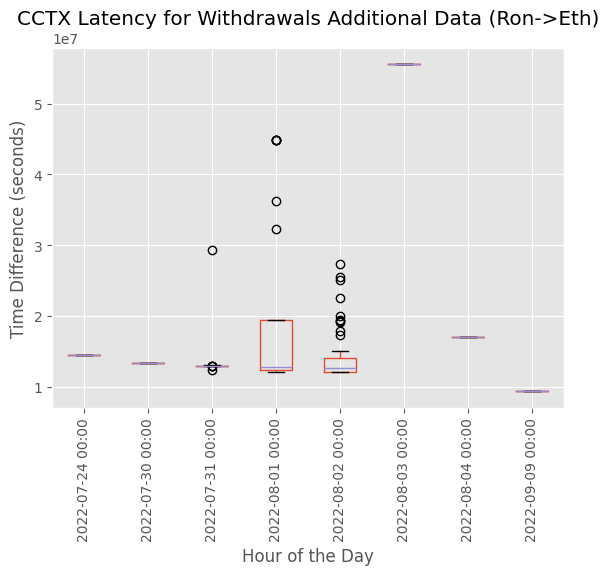

In [259]:
plotTimeDifferencesBoxplot(cctxs, False, "CCTX Latency for Withdrawals Additional Data (Ron->Eth)")

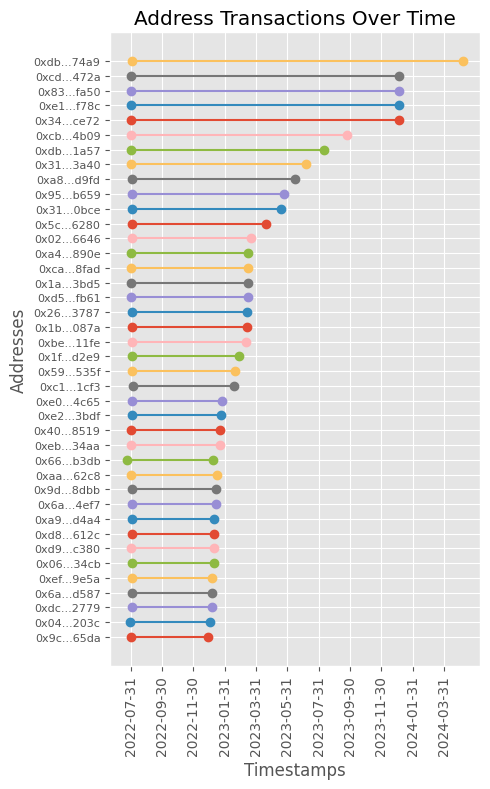

In [271]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the CSV has columns: 'address', 'timestamp1', 'timestamp2'
# Convert timestamps to datetime if they are not already
cctxs['timestamp1'] = pd.to_datetime(cctxs.iloc[:,1], unit='s')
cctxs['timestamp2'] = pd.to_datetime(cctxs.iloc[:,4], unit='s')
cctxs.rename(columns={cctxs.columns[2]: 'tx_hash'}, inplace=True)

cctxs['shot_hashes'] = [shorten_tx_hash(tx_hash) for tx_hash in cctxs['tx_hash']]

cctxs = cctxs.sort_values(by='time_difference')

df = cctxs[['shot_hashes', 'timestamp1', 'timestamp2', 'time_difference']].tail(40)

# Create the plot
plt.figure(figsize=(5, 8))

# Plot each pair of timestamps for each address
for _, row in df.iterrows():
    plt.plot([row['timestamp1'], row['timestamp2']], [row['shot_hashes'], row['shot_hashes']], marker='o')

min_date = df['timestamp1'].min()
max_date = df[['timestamp1', 'timestamp2']].max().max()

# Create date range with 2-week intervals
date_range = pd.date_range(start=min_date, end=max_date, freq='2ME')

def shorten_tx_hash(tx_hash, length=4):
    return f"{tx_hash[:length]}...{tx_hash[-length:]}"

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Addresses')
plt.title('Address Transactions Over Time')
plt.tight_layout()

plt.xticks(ticks=date_range, labels=[date.strftime('%Y-%m-%d') for date in date_range], rotation=90)
plt.yticks(ticks=df['shot_hashes'], fontsize=8)
# Show plot
plt.tight_layout()

plt.show()

The one from the top is verified here (a withdrawal with id `5324`):
https://moonscan.io/tx/0xdb3c25791d3d75053cc036c9fe9ea8410dba33add1c393fec8727444212974a9#eventlog
https://etherscan.io/tx/0x5b03906083c10a01a8271bde34d44f0eebdb977ccf7c408c2aace0cac07c8481#eventlog